Author: Bram van Duinen

Last edit date: 4 december 2023

Content: Calculating the anomalies of meteorological variables (wind speed, insolation, surface temperature) with respect to their monthly means for co-occurring events between two chosen countries, and also for cases where country_1 has an event, but country_2 does not.

TODO:
- The calculation of the anomalies is really slow. See how it can be sped up.

In [193]:
#TODO: The calculation of the anomalies is really slow. See how it can be sped up.
#TODO: Calculation of mean (composite) anomalies is now really ugly, but it works. The 'nicer' way did not work yet. Try to find out why.

In [194]:
import os
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import cartopy
# from scipy.ndimage import minimum_filter, maximum_filter
import pandas as pd
from matplotlib.colors import TwoSlopeNorm
from datetime import datetime, timedelta

In [195]:
date_now = datetime.now()
rundate = '%4.4i%2.2i%2.2i' % (date_now.year,date_now.month,date_now.day)

window = 7 # days
# Create folders for Figures from today
dir_Figures = f'../Results/Figures/{rundate}/co_occur'

if not os.path.exists(dir_Figures):
    print('Creating dir %s' % dir_Figures)
    os.makedirs(dir_Figures)

In [196]:
rundate_cooccur = 20231124
df_cooccurrences = pd.read_csv(f'../Results/df_co_occurrences_w={window}_{rundate_cooccur}.csv')

In [197]:
BASE = '/net/pc230050/nobackup/users/duinen/runmean_7d/'
BASE_CLIM  = '/net/pc200256/nobackup/users/most/LENTIS/present/climatology/'

In [198]:
def load_cooccurrences(c_1, c_2):
    co = df_cooccurrences[(df_cooccurrences['country_1'] == c_1) & (df_cooccurrences['country_2'] == c_2)]
    date_co = co['date_1'].values
    run_co = co['run'].values

    co_self = df_cooccurrences[(df_cooccurrences['country_1'] == c_1) & (df_cooccurrences['country_2'] == c_1)]

    co = co.copy()
    co_self = co_self.copy()

    num_co = len(co)

    co['key'] = co['date_1'].astype(str) + '-' + co['run'].astype(str)

    # Removing duplicates (values where 1 event in country 1 co-occurs with multiple events in country 2)
    co = co[~co['key'].duplicated()]

    num_co = len(co)

    co_self['key'] = co_self['date_1'].astype(str) + '-' + co_self['run'].astype(str)

    noco = co_self[~co_self['key'].isin(co['key'])]
    num_noco = len(noco)

    date_noco = noco['date_1'].values
    run_noco = noco['run'].values

    co_total = num_co + num_noco #should be 160
    if co_total != 160:
        print('Error: co_total != 160')
    
    return date_co, run_co, date_noco, run_noco 

In [199]:
def load_data(type):
    data = xr.open_mfdataset(BASE + type + '/h*.nc', concat_dim='run', combine="nested")
    data['run'] = data['run'] + 10

    data_clim = xr.open_dataset(BASE_CLIM + type + '_ydaymean.nc').convert_calendar('noleap')
    dayofyear = data_clim['time'].dt.dayofyear

    # Replace the 'time' dimension with 'dayofyear'
    data_clim['time'] = dayofyear
    # Now 'time' is actually 'dayofyear'
    data_clim = data_clim.rename({'time': 'dayofyear'})

    return data, data_clim

In [200]:
def calculate_anomaly(data, data_clim, varname, groupby_type="time.dayofyear"):
    data = data[varname].groupby(groupby_type)
    return data - data_clim[varname]

In [210]:
def anom_co_noco(anom, date_co, run_co, date_noco, run_noco): #is not really faster, but it is a lot cleaner
    num_co = len(date_co)
    anom_co = np.nansum([anom.sel(time=t, run=r) for t, r in zip(date_co, run_co)], axis=0) / num_co

    num_noco = len(date_noco)
    anom_noco = np.nansum([anom.sel(time=t, run=r) for t, r in zip(date_noco, run_noco)], axis=0) / num_noco

    return anom_co, anom_noco

In [202]:
def plot(type, anom_co, anom_noco, c_1, c_2, lats, lons):
    if type == 'wind':
        levels_full = np.linspace(-3, 3, 21)
        cticks_full = [-3, -2, -1, 0, 1, 2, 3]
        levels_small = np.linspace(-1, 1, 21)
        cticks_small = [-1, -0.5, 0, 0.5, 1]
        cbar_label = '[m/s]'
    elif type == 'temp':
        levels_full = np.linspace(-15, 15, 21)
        cticks_full = [-15, -10, -5, 0, 5, 10, 15]
        levels_small = np.linspace(-5, 5, 21)
        cticks_small = [-5, -2.5, 0, 2.5, 5]
        cbar_label = '[\u00b0C]'
    elif type == 'sun':
        levels_full = np.linspace(-50, 50, 21)
        cticks_full = [-50, -25, 0, 25, 50]
        levels_small = np.linspace(-10, 10, 21)
        cticks_small = [-10, -5, 0, 5, 10]
        cbar_label = '[W/m\u00b2]'

    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 10), subplot_kw={'projection': ccrs.PlateCarree()})

    data_vars = [anom_co, anom_noco - anom_co]
    levels = [levels_full, levels_small]
    cticks  = [cticks_full, cticks_small]
    titles = ['a) Co-occurrence', 'b) No co-occurrence minus co-occurrence']

    for ax, data_var, levels, cticks, title in zip(axs, data_vars, levels, cticks, titles):
        ax.set_extent([lons[0], 40, lats[0], 75])
        im1 = ax.contourf(lons, lats, data_var, levels=levels, cmap=plt.cm.RdBu_r)
        ax.coastlines()
        ax.add_feature(cartopy.feature.BORDERS, linestyle=':', alpha=1)
        gl = ax.gridlines(draw_labels=True)
        gl.top_labels = False
        gl.right_labels = False
        ax.set_title(title)

        cbar = fig.colorbar(im1, ax=ax, orientation='horizontal', label=cbar_label, pad = 0.04)
        cbar.set_ticks(cticks)    

    fig.suptitle(f'{c_1} vs {c_2}', x = 0.13, y = 0.75)
    plt.subplots_adjust(wspace=0.1, hspace=0.1)

    plt.savefig(f'{dir_Figures}/{c_1}_{c_2}_{type}.png', dpi=300, bbox_inches='tight')
    

In [211]:
def plotmeteo_all(c_1, c_2):
    date_co, run_co, date_noco, run_noco = load_cooccurrences(c_1, c_2)

    print('Starting to load data...')
    wind, wind_clim = load_data('sfcWind_d')
    temp, temp_clim = load_data('tas_d')
    sun, sun_clim = load_data('rsds_d')

    wind_anom = calculate_anomaly(wind, wind_clim, 'sfcWind')
    temp_anom = calculate_anomaly(temp, temp_clim, 'tas')
    sun_anom = calculate_anomaly(sun, sun_clim, 'rsds')

    print('Starting to calculate anomalies...')
    wind_anom_co, wind_anom_noco = anom_co_noco(wind_anom, date_co, run_co, date_noco, run_noco)
    temp_anom_co, temp_anom_noco = anom_co_noco(temp_anom, date_co, run_co, date_noco, run_noco)
    sun_anom_co, sun_anom_noco = anom_co_noco(sun_anom, date_co, run_co, date_noco, run_noco)

    lats = wind.lat.values
    lons = wind.lon.values

    print('Starting to plot...')
    plot('wind', wind_anom_co, wind_anom_noco, c_1, c_2, lats, lons)
    plot('temp', temp_anom_co, temp_anom_noco, c_1, c_2, lats, lons)
    plot('sun', sun_anom_co, sun_anom_noco, c_1, c_2, lats, lons)

    print('Done')

Starting to load data...
Starting to calculate anomalies...
Starting to plot...
Done


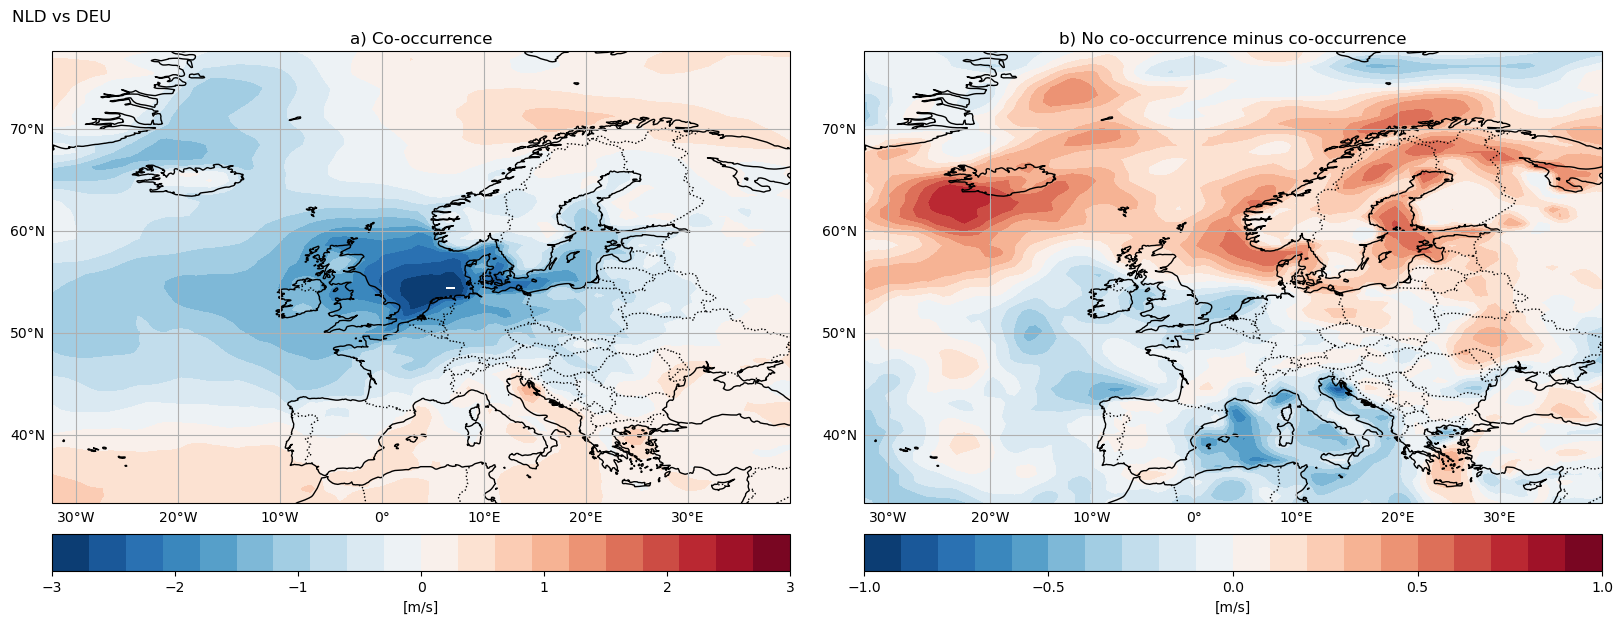

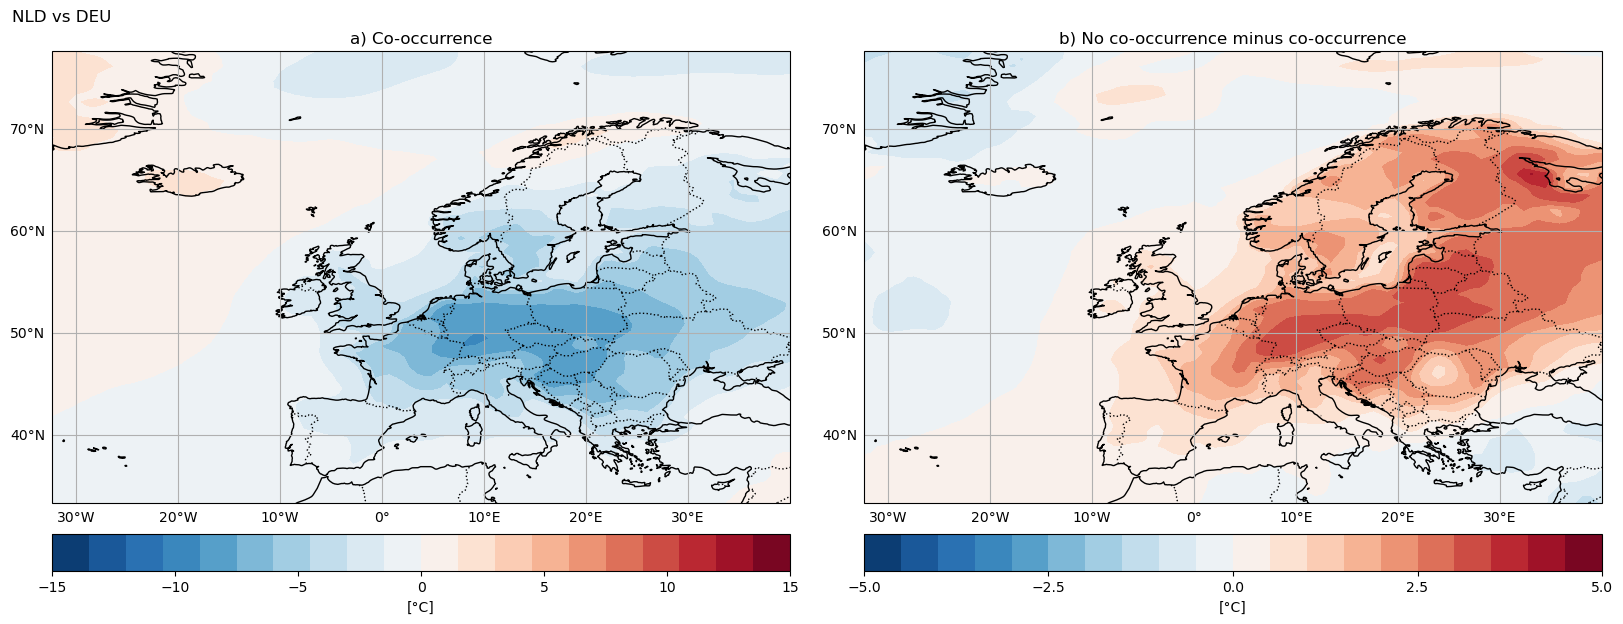

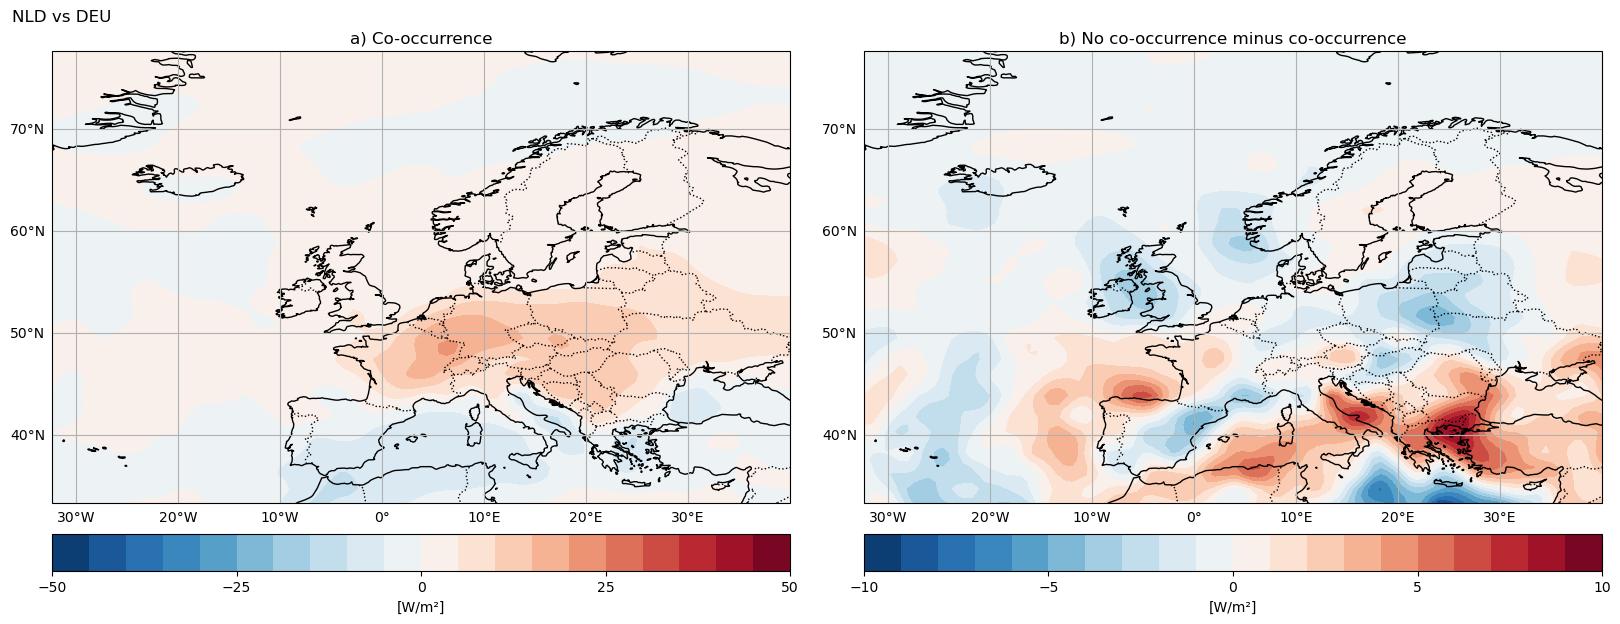

In [212]:
plotmeteo_all('NLD', 'DEU')